# **Football Wages Cleaning**

# **Importing Data**

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [60]:
df=pd.read_csv('/content/raw_wages.csv')
df.shape

(40791, 16)

In [61]:
df.head()

,Name,Club,Division,Based,Nat,EU National,Caps,AT Apps,Position,Age,CR,Begins,Expires,Last Club,Last Trans. Fee,Salary
0,Cristiano Ronaldo - Portuguese,Al-Nassr (KSA) - Roshn Saudi League,Roshn Saudi League ...,Saudi Arabia (Saudi Pro League) ...,POR,Yes,200.0,673,ST (C),38.0,"7,629",31/12/2022,30/6/2025,,-,"€203,478,000 p/a"
1,Karim Benzema - French,Al-Ittihad - Roshn Saudi League,Roshn Saudi League ...,Saudi Arabia (Saudi Pro League) ...,FRA,Yes,97.0,555,ST (C),35.0,"8,250",1/7/2023,30/6/2025,,-,"€199,452,000 p/a"
2,Neymar - Brazilian,Al-Hilal (KSA) - Roshn Saudi League,Roshn Saudi League ...,Saudi Arabia (Saudi Pro League) ...,BRA,Yes,124.0,340,"AM (LC), ST (C)",31.0,"9,000",15/8/2023,30/6/2025,Paris Saint-Germain,€90M,"€149,589,000 p/a"
3,Ezri Konsa - English,Al-Hilal (KSA) - Roshn Saudi League,Roshn Saudi League ...,Saudi Arabia (Saudi Pro League) ...,ENG,No,0.0,245,D (C),25.0,"7,414",27/8/2023,30/6/2027,Aston Villa,€55M,"€74,157,000 p/a"
4,Kylian Mbappé - French,Paris Saint-Germain - Ligue 1 Uber Eats,Ligue 1 Uber Eats ...,France (Ligue 1) ...,FRA,Yes,70.0,221,"AM (RL), ST (C)",24.0,"9,415",22/7/2023,30/6/2028,Monaco,€186M,"€48,467,000 p/a"


In [62]:
df.describe()

,Caps,Age
count,40791.000000,40791.000000
mean,5.144370,25.177564
std,13.665878,5.328114
min,0.000000,17.000000
25%,0.000000,21.000000
50%,0.000000,25.000000
75%,3.000000,29.000000
max,200.000000,45.000000


In [63]:
for i in df.columns:
    df[i] = df[i].apply(lambda x: str(x).strip())

In [64]:
df.replace('-', np.nan, inplace=True)
df.replace('', np.nan, inplace=True)

In [65]:
null_values = df.isna().sum()/len(df)
null_values

Name               0.000000
Club               0.999779
Division           0.005467
Based              0.000000
Nat                0.000000
EU National        0.000000
Caps               0.000000
AT Apps            0.134270
Position           0.999779
Age                0.000000
CR                 0.000000
Begins             0.000000
Expires            0.000564
Last Club          0.354098
Last Trans. Fee    0.566326
Salary             0.000000
dtype: float64

<Axes: >

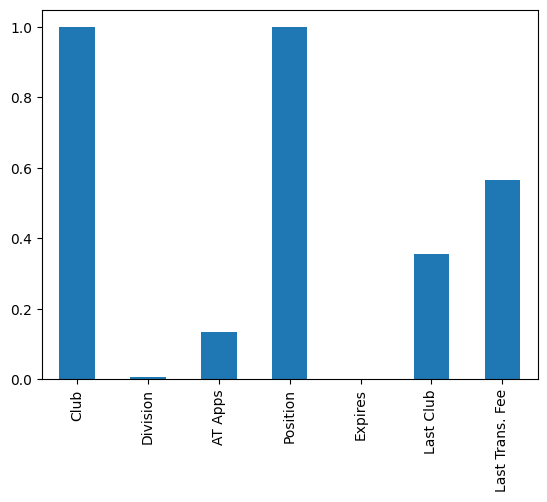

In [66]:
null_values[null_values>0].plot(kind='bar')

**Data Preprocessing**

In [67]:
df = df.drop(['Name', 'Club', 'Position'], axis=1)
df.sample(5)

,Division,Based,Nat,EU National,Caps,AT Apps,Age,CR,Begins,Expires,Last Club,Last Trans. Fee,Salary
766,Premier League,England (Premier League),USA,No,36.0,185,24.0,"7,122",20/8/2023,30/6/2028,Leeds Utd,€27M,"€3,032,000 p/a"
23869,Ligue 1 Uber Eats,France (Ligue 1),FRA,Yes,0.0,NaN,17.0,"3,609",4/7/2022,30/6/2024,NaN,NaN,"€33,500 p/a"
26494,French Regional 1 - Auvergne Rhône Alpes - Gro...,France (R1 - Auvergne RA - C),FRA,Yes,0.0,1,19.0,"3,000",1/7/2023,30/6/2024,NaN,NaN,"€25,000 p/a"
26881,French National 3 - Group C,France (National 3 - Group C),FRA,Yes,0.0,46,26.0,"4,300",1/7/2023,30/6/2024,NaN,NaN,"€24,500 p/a"
28968,DPR Korea League,North Korea (DPR Korea League),PRK,No,1.0,11,27.0,"4,550",6/7/2020,31/12/2024,NaN,NaN,"€19,500 p/a"


In [68]:
top_5_leagues = ['Premier League', 'LALIGA EA SPORTS', 'Ligue 1 Uber Eats', 'Serie A TIM', 'Bundesliga']
df['Is_top_5_League'] = df['Division'].apply(lambda x: 1 if x in top_5_leagues else 0)

df.drop('Division', axis=1, inplace=True)

In [69]:
# Converting leagues' nations to rich nations with monetary power to pull players
rich_nat = [
    "England",
    "China",
    "Germany",
    "Spain",
    "France",
    "Italy",
    "United States",
    "Qatar",
    "U.A.E.",
    "Saudi Arabia"]

df['Based_rich_nation'] = df['Based'].apply(lambda x: 1 if x.split(' (')[0] in rich_nat else 0)
df.drop('Based', axis=1, inplace=True)

In [70]:
#Converting all nations into tiers of nations

tier1 = [
    "ARG",  # Argentina
    "FRA",  # France
    "ENG",  # England
    "BEL",  # Belgium
    "BRA",  # Brazil
    "NED",  # Netherlands
    "POR",  # Portugal
    "ESP",  # Spain
    "ITA",  # Italy
    "CRO",  # Croatia
]

tier2 = [
    "URU",  # Uruguay
    "MAR",  # Morocco
    "USA",  # USA
    "COL",  # Colombia
    "MEX",  # Mexico
    "GER",  # Germany
    "SEN",  # Senegal
    "JPN",  # Japan
    "SUI",  # Switzerland
    "IRN",  # Iran
    "DEN",  # Denmark
    "KOR",  # Korea Republic
    "AUS",  # Australia
    "UKR",  # Ukraine
    "AUT",  # Austria
    "SWE",  # Sweden
    "HUN",  # Hungary
    "NGA",  # Nigeria
    "WAL",  # Wales
    "POL"]

df['Is_top_ranked_nation'] = df['Nat'].apply(lambda x: 2 if x in tier1 else (1 if x in tier2 else 0))
df.drop('Nat', axis=1, inplace=True)

In [71]:
#Mapping EU National from YES/NO to 1/0
df['EU_National'] = df['EU National'].map({'Yes': 1, 'No': 0})

In [72]:
#Adding numerical df to our new df

df['AT Apps'] = df['AT Apps'].fillna(0).astype(int)
df['CR'] = df['CR'].str.replace(',', '').astype(float)
df['Last Trans. Fee'] = df['Last Trans. Fee'].fillna('€0')

In [73]:
#Checking to see if player's prev club was a top club which might indicate a higher wage

top_clubs = ['Real Madrid', 'Bayern München', 'Barcelona', 'Man City', 'Juventus', 'Chelsea', 'Atlético de Madrid', 'Liverpool', 'Paris Saint-Germain', 'Sevilla', 'Man Utd', 'Dortmund', 'Porto', 'Arsenal', 'Benfica', 'Ajax', 'Roma', 'Napoli', 'Tottenham', 'Shakhtar']

df['Is_top_prev_club'] = df['Last Club'].apply(lambda x: 1 if x in top_clubs else 0)
df.drop('Last Club', axis=1, inplace=True)

In [74]:
#Converting last transfer fee into numerical df
def last_trans_fee_conversion(amt):
    if amt =='€0':
        return 0
    elif amt[-1] == 'M':
        return float(amt[1:-1])*1e+6
    elif amt[-1] == 'K':
        return float(amt[1:-1])*1e+3
    else:
        return float(amt[1:])

df['Last_Transfer_Fee'] = df['Last Trans. Fee'].apply(lambda x: last_trans_fee_conversion(x))
df.drop('Last Trans. Fee', axis=1, inplace=True)

In [75]:
df['Salary'][0]

'€203,478,000 p/a'

In [76]:
#Converting Salary into numerical
df['Salary'] = df['Salary'].apply(lambda x: float(x[1:].split()[0].replace(',', '')))

In [77]:
df['Expires'] = df['Expires'].fillna(datetime.now().strftime("%d/%m/%y"))

In [78]:
df['Expires'] = pd.to_datetime(df['Expires'], dayfirst=True, format="mixed")
df['Begins'] = pd.to_datetime(df['Begins'], dayfirst=True, format="mixed")

In [79]:
df['Duration'] = df.apply(lambda x: (x['Expires'] - x['Begins']).days, axis=1)
df.drop(['Begins','Expires'], axis=1, inplace=True)

In [80]:
df[['Age', 'Caps', 'EU National']] = df[['Age', 'Caps', 'EU National']].apply(pd.to_numeric, errors='coerce').fillna(0)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40791 entries, 0 to 40790
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   EU National           40791 non-null  float64
 1   Caps                  40791 non-null  float64
 2   AT Apps               40791 non-null  int64  
 3   Age                   40791 non-null  float64
 4   CR                    40791 non-null  float64
 5   Salary                40791 non-null  float64
 6   Is_top_5_League       40791 non-null  int64  
 7   Based_rich_nation     40791 non-null  int64  
 8   Is_top_ranked_nation  40791 non-null  int64  
 9   EU_National           40791 non-null  int64  
 10  Is_top_prev_club      40791 non-null  int64  
 11  Last_Transfer_Fee     40791 non-null  float64
 12  Duration              40791 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 4.0 MB


In [82]:
df.isnull().sum()

EU National             0
Caps                    0
AT Apps                 0
Age                     0
CR                      0
Salary                  0
Is_top_5_League         0
Based_rich_nation       0
Is_top_ranked_nation    0
EU_National             0
Is_top_prev_club        0
Last_Transfer_Fee       0
Duration                0
dtype: int64

# **EDA**

In [83]:
df

,EU National,Caps,AT Apps,Age,CR,Salary,Is_top_5_League,Based_rich_nation,Is_top_ranked_nation,EU_National,Is_top_prev_club,Last_Transfer_Fee,Duration
0,0.0,200.0,673,38.0,7629.0,203478000.0,0,1,2,1,0,0.0,912
1,0.0,97.0,555,35.0,8250.0,199452000.0,0,1,2,1,0,0.0,730
2,0.0,124.0,340,31.0,9000.0,149589000.0,0,1,2,1,1,90000000.0,685
3,0.0,0.0,245,25.0,7414.0,74157000.0,0,1,2,0,0,55000000.0,1403
4,0.0,70.0,221,24.0,9415.0,48467000.0,1,1,2,1,0,186000000.0,1805
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40786,0.0,5.0,59,31.0,1508.0,300.0,0,0,0,0,0,0.0,1825
40787,0.0,6.0,1,21.0,2750.0,300.0,0,0,0,0,0,0.0,1000
40788,0.0,2.0,3,24.0,3550.0,300.0,0,0,0,0,0,0.0,730
40789,0.0,3.0,14,20.0,1403.0,300.0,0,0,0,0,0,0.0,1460


In [84]:
average_salary = df.groupby('Is_top_5_League')['Salary'].mean()
print('Average Salary by Top 5 League:')
print(average_salary)

Average Salary by Top 5 League:
Is_top_5_League
0    1.907863e+05
1    1.277738e+06
Name: Salary, dtype: float64


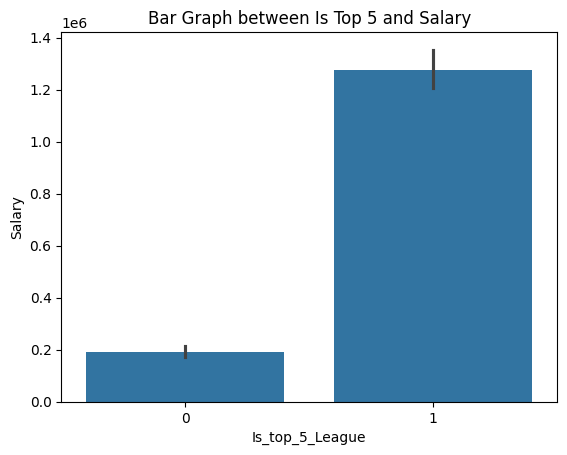

In [85]:
sns.barplot(x='Is_top_5_League', y='Salary', data=df)
plt.title('Bar Graph between Is Top 5 and Salary')
plt.show()

In [86]:
average_salary = df.groupby('Based_rich_nation')['Salary'].mean()
print('Average Salary by Based_rich_nation:')
print(average_salary)

Average Salary by Based_rich_nation:
Based_rich_nation
0    161825.567580
1    444351.295251
Name: Salary, dtype: float64


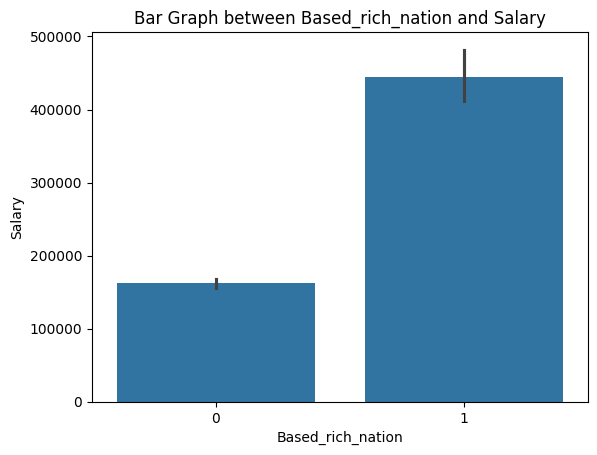

In [87]:
sns.barplot(x='Based_rich_nation', y='Salary', data=df)
plt.title('Bar Graph between Based_rich_nation and Salary')
plt.show()

In [88]:
average_salary = df.groupby('Is_top_ranked_nation')['Salary'].mean()
print('Average Salary by Top Ranked Nation:')
print(average_salary)

Average Salary by Top Ranked Nation:
Is_top_ranked_nation
0    211872.507875
1    396623.449555
2    377052.107338
Name: Salary, dtype: float64


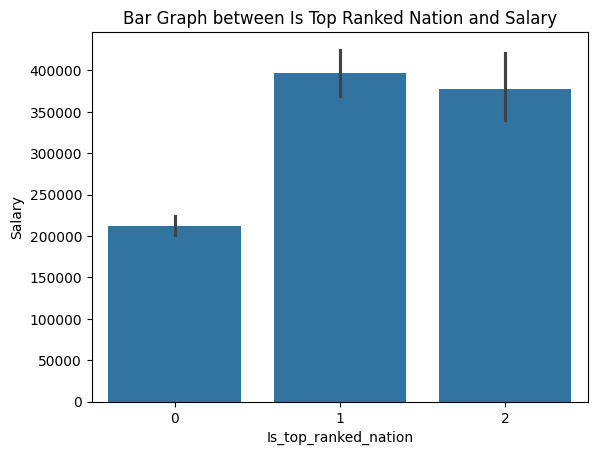

In [89]:
sns.barplot(x='Is_top_ranked_nation', y='Salary', data=df)
plt.title('Bar Graph between Is Top Ranked Nation and Salary')
plt.show()

In [90]:
average_salary = df.groupby('EU_National')['Salary'].mean()
print('Average Salary by EU_National:')
print(average_salary)

Average Salary by EU_National:
EU_National
0    292055.797194
1    335549.827442
Name: Salary, dtype: float64


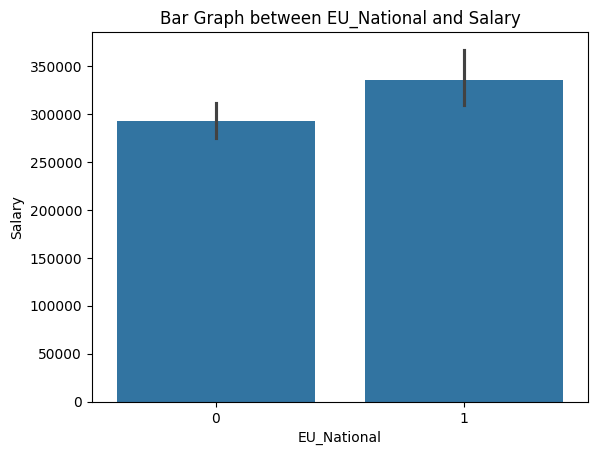

In [91]:
sns.barplot(x='EU_National', y='Salary', data=df)
plt.title('Bar Graph between EU_National and Salary')
plt.show()

In [92]:
average_salary = df.groupby('Is_top_prev_club')['Salary'].mean()
print('Average Salary by Top Previous Club:')
print(average_salary)

Average Salary by Top Previous Club:
Is_top_prev_club
0    2.657387e+05
1    2.288762e+06
Name: Salary, dtype: float64


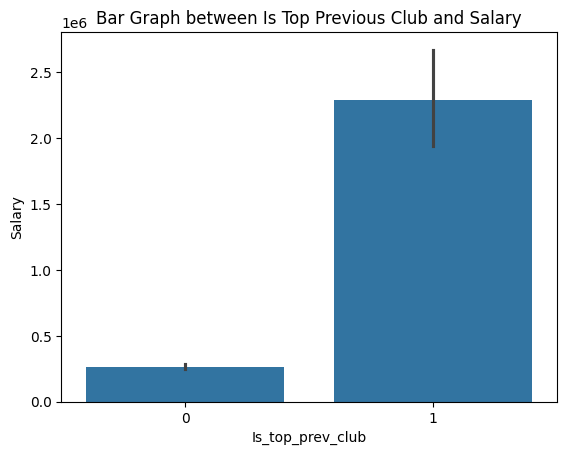

In [93]:
sns.barplot(x='Is_top_prev_club', y='Salary', data=df)
plt.title('Bar Graph between Is Top Previous Club and Salary')
plt.show()

In [94]:
'''
!pip install sweetviz
import sweetviz as sv
rpt = sv.analyze(df)
rpt.show_notebook()
'''


'\n!pip install sweetviz\nimport sweetviz as sv\nrpt = sv.analyze(df)\nrpt.show_notebook()\n'

In [95]:
df.describe()['Salary']

count    4.079100e+04
mean     3.189044e+05
std      2.006071e+06
min      1.800000e+02
25%      1.650000e+04
50%      4.450000e+04
75%      1.560000e+05
max      2.034780e+08
Name: Salary, dtype: float64

# **Training the Model**

In [96]:
x=df.drop('Salary',axis=1)
y=df['Salary']

In [97]:
scaler=MinMaxScaler()
x=scaler.fit_transform(x)

In [98]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Train a linear regression model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Train a Polynomial regression model
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)

# Train a k-nearest neighbors regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train, y_train)

# Test the models
lr_score = lr.score(x_test, y_test)
dt_score = dt.score(x_test, y_test)
knn_score = knn.score(x_test, y_test)

print("Linear regression R2 score:", lr_score)
print("Decision Tree regression R2 score:", dt_score)
print("KNN R2 score:", knn_score)


Linear regression R2 score: 0.4394698567779951
Decision Tree regression R2 score: 0.5563056571902594
KNN R2 score: 0.480867956777727


In [100]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create the voting regressor
estimators = [ ('dt', dt), ('knn', knn)]
vreg = VotingRegressor(estimators)

# Train the voting regressor
vreg.fit(x_train, y_train)

# Make predictions
y_pred = vreg.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Voting Regressor:")
print("- MSE:", mse)
print("- RMSE:", rmse)
print("- R2:", r2)

Voting Regressor:
- MSE: 952701505108.8455
- RMSE: 976064.2935323705
- R2: 0.5698857735981497


In [101]:
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
rf = RandomForestRegressor()

# Train the random forest regressor
rf.fit(x_train, y_train)

# Make predictions
y_pred = rf.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor:")
print("- MSE:", mse)
print("- RMSE:", rmse)
print("- R2:", r2)

Random Forest Regressor:
- MSE: 1032873087492.3665
- RMSE: 1016303.6394170624
- R2: 0.53369087104852


In [102]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 2761085951743.2964
Root Mean Squared Error: 1661651.5735085066
R-squared: -0.24654190404307585


In [103]:
# Create an Extra Trees regressor
et = ExtraTreesRegressor()

# Train the Extra Trees regressor
et.fit(x_train, y_train)

# Make predictions
y_pred = et.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Extra Trees Regressor:")
print("- MSE:", mse)
print("- RMSE:", rmse)
print("- R2:", r2)

Extra Trees Regressor:
- MSE: 877088479190.4127
- RMSE: 936530.0204427047
- R2: 0.6040226338575383


In [ ]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(data)
labels

In [ ]:
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans

kmodes_test = KModes(n_clusters=3,verbose=1,n_init=2)
Clusters = kmodes_test.fit_predict(data)

kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 101)
kmeans.fit(data) 